# Clase 04b: Integración de datos vectoriales y Raster

------

## Objetivos de esta Notebook:

Luego de haber aprendido algunas operaciones de manejo básico de datos vectoriales, en esta notebook veremos algunas nociones básicas sobre cómo integrarlos con datos raster. Seguiremos usando `geopandas` e introduciremos además la librería `Rasterio` como alternativa a GDAL para procesar nuestras imágenes y extraer información.

### Datos con los que trabajaremos en esta notebook:

- Imagen SPOT 7 con la que trabajamos en la clase anterior, calibrada a reflectancia a tope de la atmósfera (**data/raw_data/SPOT_20170806_MS_p.tif**).
- Una imagen Sentinel-2 de la misma zona de estudio (archivo **data/raw_data/S2_20180619_2-3-4-8-11-12.tif**).
- Capa vectorial de rutas y cursos de agua que atraviesan la zona de estudio.
- Capa vectorial de radios censales con las transformaciones realizadas en la notebook anterior.

## Un poco sobre la filosofía de Rasterio

_El siguiente párrafo está adaptado del [sitio](https://rasterio.readthedocs.io/en/stable/intro.html) de Rasterio_

Antes de Rasterio la principal manera de trabajar en Python con los formatos Raster utilizados en entorno SIG era GDAL (la librería que usamos hasta ahora). El problema de GDAL es que se parece más a una librería clásica de C con lo cual implica trabajar o progamar más en bajo nivel. Rasterio viene a ser la adaptación de GDAL para las convenciones de Python: Usa esta librería como base, pero permite al usuario trabajar a más alto nivel.

En las Clases 02 y 03 aprendimos GDAL porque consideramos que es necesario entender las bases sobre las cuales se trabaja con archivos raster, pero en esta clase veremos que Rasterio puede ser mucho más amigable logrando los mismos resultados.

## 1. Lectura de archivos raster con Rasterio

Rasterio es un módulo de procesamiento de Python que está basado principalmente en GDAL y , por lo tanto, puede leer y escribir en todos los formatos de raster que ofrece GDAL. Ofrece algunas ventajas en cuanto a funcionalidades que ahorran mucho trabajo al usuario, y usaremos algunas de estas en esta clase.

Para comenzar, levantaremos nuestras imagen Sentinel-2 (archivo **S2_20180619_2-3-4-8-11-12.tif**) con Rasterio y leeremos algunas de sus propiedades para entender cómo las interpreta esta biblioteca respecto a lo que vimos en las Clases 02 y 03.

La imagen Sentinel 2 que hemos preparado para esta notebook contiene 6 bandas:

- Banda 1: Azul
- Banda 2: Verde
- Banda 3: Rojo
- Banda 4: Infrarrojo Cercano (NIR)
- Banda 5: Infrarrojo de Onda Corta 1 (SWIR 1)
- Banda 6: Infrarrojo de Onda Corta 2 (SWIR 2).

Más especificaciones sobre las bandas de Sentinel 2 se pueden encontrar en [este enlace](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/resolutions/spatial)

```python
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../')
import rasterio
from osgeo import gdal
import geopandas as gpd
import numpy as np


s2 = rasterio.open('../data/raw_data/S2_20180619_2-3-4-8-11-12.tif')
print(f'El tipo de objeto al abrir con Rasterio es: {type(s2)}')

s22 = gdal.Open('../data/raw_data/S2_20180619_2-3-4-8-11-12.tif')
print(f'El tipo de objeto al abrir con GDAL es: {type(s22)}')
s22 = None
```

Como se puede ver, tanto GDAL como Rasterio traducen a las imágenes en clases, sobre las que podremos aplicar ciertos métodos y que tendrán ciertos atributos. En esos métodos y atributos radican las principales diferencias entre ambas librerías. Veamos como se leen algunos de los principales atributos con Rasterio:

```python
#Proyección
print(s2.crs)

#Geotransform:
print(s2.transform)

# Dimensiones y cantidad de bandas
print(s2.width)
print(s2.height)
print(f'Número de bandas: {s2.count}')

#Extensión:
print(s2.bounds)

#Metadatos:
print(s2.meta)
```

En este último parámetro (metadatos) se resume toda la información del Raster, con estructura de diccionario. Cuando escribamos imágenes modificadas vamos a editar principalmente este atributo. 

Para leer las bandas como matrices o arreglos de Numpy, el código es muy parecido a GDAL:

```python
s2_bandas = s2.read()

s2_bandas.shape
```

Corroboramos que se ha leido correctamente usando la función plot_rgb que creamos en la Clase 3:

```python
import funciones as fn
fn.plot_rgb(s2_bandas, [2,1,0], p = 2)
fn.plot_rgb(s2_bandas, [5,3,2], p = 2)
```

## 2. Visualización de datos vectoriales y raster en conjunto

Ahora vamos a abrir nuestro vector de radios censales (puede ser el archivo **radios_merge_viv_personas.shp** o su análogo en formato Geopackage, o también el archivo **radios_recorte_utm.shp** original) trabajado en la Notebook anterior, y lo vamos a superponer con nuestra imagen Sentinel. 

Plotear datos vectoriales y raster por separado en Python es relativamente sencillo. Sin embargo, cuando los queremos ver en conjunto hay que tener en cuenta la extensión espacial (o _extent_ in inglés) que debe ocupar cada uno en la figura. También es importante que las capas tengan la misma proyección (o _CRS_ para Rasterio).

```python
# Puede ser también el archivo original ../data/raw_data/radios_recorte_utm
radios = gpd.read_file('../data/raw_data/vector/radios_recorte_utm.shp')
print(s2.crs)
print(radios.crs)
```

Las capas tienen el mismo CRS. Ahora, para que podamos superponer las dos fuentes de información en el mismo gráfico, debemos explicitar cuál será la extensión a graficar con el parámetro **extent**. Para ello, primero usaremos una función de Rasterio que nos permite obtener esos límites:

```python
from rasterio.plot import plotting_extent
s2_plot_extent = plotting_extent(s2)

print(s2_plot_extent)
```

Los valores del _extent_ de nuestra imagen no difieren mucho de lo que nos devuelve **bounds**. Sin embargo, **plot_extent** devuelve una tupla con un orden de coordenadas que Matplotlib puede interpretar correctamente:

```python
print(type(s2.bounds))
print(type(s2_plot_extent))
```

Probemos ahora superponer los radios con una de las bandas de nuestra imagen Sentinel:

```python
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize = (12,6))
ax.imshow(s2_bandas[0,:,:], extent = s2_plot_extent, cmap = 'gray')
radios.plot(ax=ax)
plt.show()
```

A simple vista pareciera que solo se graficaron los polígonos de los radios censales. Sin embargo, la imagen está también, solo que por debajo. Si aplicamos un poco de transparencia al vector la vamos a ver:

```python
fig, ax = plt.subplots(figsize = (12,6))
ax.imshow(s2_bandas[0,:,:], extent = s2_plot_extent, cmap = 'gray')
radios.plot(ax=ax, alpha = 0.5)
plt.show()
```

Para evitar tener que hacer desaparecer nuestra capa de radios, podemos usar el atributo **boundary** para plotear solo sus bordes, y darles un color que resalte bien con el parámetro **edgecolor**:

```python
fig, ax = plt.subplots(figsize = (12,6))
ax.imshow(s2_bandas[0,:,:], extent = s2_plot_extent, cmap = 'gray')
radios.boundary.plot(ax=ax, edgecolor = 'red')
plt.show()
```

Podemos también superponerlo con un RGB, para lo cual podemos generar primero un stack listo para plotear con **scale_multiband()**, la función que traemos de la Clase 03:

```python
import funciones as fn
rgb = fn.scale_multiband(s2_bandas, p=2)
fig, ax = plt.subplots(figsize = (12,6))
ax.imshow(rgb[[5,3,2]].transpose(1,2,0), extent = s2_plot_extent)
radios.boundary.plot(ax=ax, edgecolor = 'red')
plt.title("Combinación bandas S2: 5-3-2")
plt.show()
```

#### Otra alternativa

Otra manera de plotear conjuntamente los datos vectoriales y raster es usar la función **show** de Rasterio para el Raster, agregando el parámetro **transform** que debe especificar el GeoTransform de la matriz.

La diferencia con `imshow()` es que cuando a esta función le pasamos una matriz de 3 dimensiones, la misma debe estar ordenada en `[bandas, filas, columnas]`, con lo cual ya no es necesario usar `transpose()`:

```python
from rasterio.plot import show 
fig, ax = plt.subplots(figsize=(12,12)) 
radios.boundary.plot(ax=ax, color='orangered') 
show(rgb[[5,3,2]],transform = s2.transform, ax=ax)
plt.show()
```

A continuación, se deja a disposición la siguiente función que trabaja muy parecido a `scale()` y `scale_multiband()`, y además tiene algunas particularidades que se comentarán en clase:

```python
def nequalize(array, p=2, nodata=None):
    """
    Esta función es similar a scale, solo que funciona tanto para matrices de 2 y 3 dimensiones.
    En el caso de 3 dimensiones, devuelve una matriz con la estructura (banda, fila, columna) para
    utilizarla en show() de Rasterio.
    """
    if len(array.shape)==2:
        vmin,vmax=np.percentile(array[array!=nodata],(p,100-p))
        eq_array = (array-vmin)/(vmax-vmin)
        eq_array = np.clip(eq_array,0,1)
    elif len(array.shape)==3:
        eq_array = np.empty_like(array, dtype=float)
        for i in range(array.shape[0]):
            eq_array[i]=nequalize(array[i], p=p, nodata=nodata)
    return eq_array

# Probamos el ploteo con esta función

fig, ax = plt.subplots(figsize=(12,12)) 
radios.boundary.plot(ax=ax, color='orangered') 
show(nequalize(s2_bandas)[[5,3,2]],transform = s2.transform, ax=ax)
plt.show()
```

### Ejercicio 1.1 (Opcional):

a) Leer los vectores que corresponden al Río Suquía (**data/raw_data/vector/rio_suquia_utm.shp**) y a red de accesos a Córdoba (**data/raw_data/vector/red_nacional_recorte_utm**) y graficarlos junto a la imagen Sentinel 2 y los polígonos de radios censales.

**Nota:** Se puede jugar con el parámetro **_zorder_** para cambiar el orden en que se grafican las distintan capas. [Aquí](https://matplotlib.org/3.1.1/gallery/misc/zorder_demo.html) pueden consultar una página específica donde se explica el funcionamiento de este parámetro.

## 3. Recorte de archivos raster a partir de vectores

En la Clase 03 vimos una manera de realizar recortes de nuestras imágenes como _subsets_ rectangulares o cuadrados, aplicando el _slicing_ de Numpy. En la Clase 02 también aprendimos como hacerlo con el método ReadAsArray(). Vimos además una forma bastante "manual" de re-definir el Geotransform de GDAL para poder guardar el recorte.

En esta clase veremos una manera de hacerlo de manera más sencilla con Rasterio, y utilizando además polígonos de nuestros vectores. 

Supongamos que queremos usar el polígono de radio censal resaltado en amarillo en la captura para recortar nuestro raster:

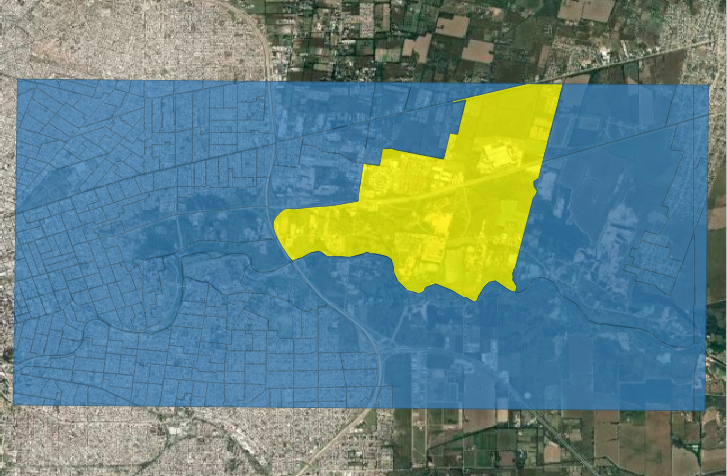

Si consultamos sus atributos en QGIS, ese polígono corresponde al Radio 5, Fracción 7, o al valor '140140705' en la columna **codigo**.

Lo que haremos primero entonces es crear un filtro de nuestro GeoDataframe que contenga solo ese polígono: eso lo podemos hacer a partir de uno de los atributos del mismo:

```python
poligono = radios.loc[radios['link'] == '140140705']
poligono.plot()
```

Ya tenemos nuestro polígono individualizado. Tenemos dos maneras de hacer nuestro _recorte_:

A) Usando la extensión espacial del polígono (con lo cual obtendríamos un rectángulo o cuadrado)

B) Usando los límites exactos del polígono. En ese caso no sería exactamente un recorte, sino una operación en **enmascarado**.

### A. Corte por extensión espacial

En el caso de A, la extensión espacial se refiere siempre al borde o línea que une las coordenadas más extremas en Norte,Sur, Este y Oeste. La siguiente figura (extraída de [esta página](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/crop-raster-data-with-shapefile-in-python/)) lo muestra más claramente para el caso de vectores:

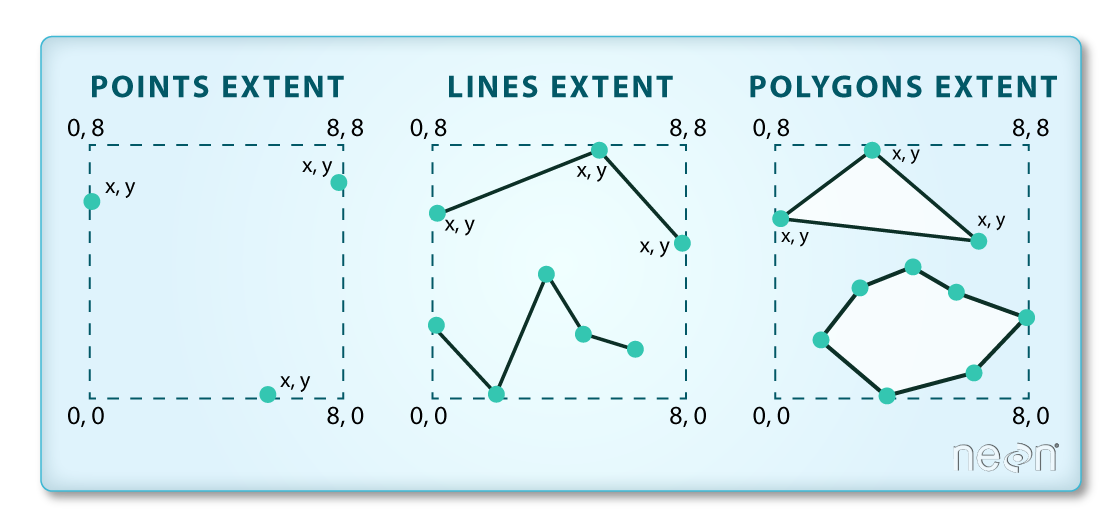

Nuestro polígono tiene su propio _extent_ , definido por las coordenadas que nos da el atributo **_bounds_**:

```python
poligono.bounds
```

Podemos crear un polígono a partir de ellas, usando el método **box** de `shapely` (recordar que `shapely` se instala junto a `geopandas`!)

```python
from shapely.geometry import box

extent_geo = gpd.GeoDataFrame(
    geometry=[box(*poligono.total_bounds)],
    crs=poligono.crs
)

#Graficamos el extent junto al polígono:
fig,ax = plt.subplots(figsize = (5,5))
extent_geo.boundary.plot(ax=ax, edgecolor = 'red')
poligono.plot(ax=ax)
plt.show()
```

¿Qué quiere decir el asterisco `*`que estamos usando en la celda anterior? En este caso el asterisco lo usamos para **desempaquetar** los 4 valores que devuelte `total_bounds`. Es una forma más corta y concisa de hacer:

```python
minx, miny, maxx, maxy = poligono.total_bounds
box(minx, miny, maxx, maxy)
```

El uso del asterisco para desempaquetar es muy útil, y lo volveremos a utilizar más adelante en esta misma notebook.

Ahora usamos **extent_geo** para hacer el recorte con la función **mask** de Rasterio:

```python
from rasterio.mask import mask
s2_clip, clip_transform = mask(dataset=s2,shapes = extent_geo.geometry, crop = True)

print('Transform original: ', s2.transform)
print('Nuevo transform: ', clip_transform)
print('Dimensiones del recorte', s2_clip.shape)
```

**Mask** nos devuelve el archivo recortado como arreglo de Numpy (lo hemos llamado **s2_clip**) y su _GeoTransform_ ya calculado (lo hemos asignado a la variable **clip_transform**)

```python
minx, miny, maxx, maxy = poligono.total_bounds
plot_extent = (minx,maxx,miny,maxy)
rgb_clip = fn.scale_multiband(s2_clip, p=2)

fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(rgb_clip[[2,1,0]].transpose(1,2,0), extent = plot_extent)
poligono.boundary.plot(ax=ax, edgecolor = 'red')
extent_geo.boundary.plot(ax=ax, edgecolor = 'yellow')
plt.title("Recorte por Extent \n Combinación bandas S2: 2-1-0")
plt.show()
```

### B. Corte por máscara

Veamos ahora como funciona la opción B, es decir recortar haciendo un **enmascarado**.

En este caso, en vez de usar el Extent, directamente usamos los límites exactos de nuestro polígono. El raster resultante **sigue siendo una matriz rectangular**, pero todos los píxeles que caen por fuera de la máscara (el polígono) quedan como valores Sin datos. La geometría que aplicamos ahora es directamente la del Geodataframe **poligono**:

```python
s2_mask, mask_transform = mask(dataset=s2,shapes = poligono.geometry, crop = True)
```

¿Qué sucederá con los pixeles que serán enmascarados? Esto se maneja con el parámetro _nodata_, que por defecto es _None_. Cuando este parámetro es nulo, _mask_ se fija cuál es el valor definido como NoData en nuestra imagen original. Si no tiene uno definido, asigna como _nodata_ el valor 0:

```python
print(s2.meta['nodata'])
```

Nuestro GeoTiff no tenía ningun valor de _nodata_ definido. Por lo tanto, el mask rellenó con 0 todos esos valores. Si queremos plotear usando nuestra función **plot_rgb()** debemos pasarle ese parámetro como _nodata_:

```python
plot_extent = (minx,maxx,miny,maxy)
rgb_mask = fn.scale_multiband(s2_mask, p=2, nodata = 0)

fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(rgb_mask[[2,1,0]].transpose(1,2,0), extent = plot_extent)
poligono.boundary.plot(ax=ax, edgecolor = 'red')
extent_geo.boundary.plot(ax=ax, edgecolor = 'yellow')
plt.title("Recorte por Máscara \n Combinación bandas S2: 2-1-10)
plt.show()
```

Esto se ve bastante diferente a **s2_clip** , verdad? Sin embargo, si imprimimos sus dimensiones son exactamente iguales:

```python
print(s2_clip.shape)
print(s2_mask.shape)
```

Lo que cambia es que ahora por afuera de los bordes de la máscara, tenemos todos píxeles con valor 0. Nosotros en realidad querríamos que sean píxeles sin datos, por lo tanto a la hora de guardar el raster recortado, lo vamos a tener que explicitar en sus metadatos.

### Escritura de los recortes en nuestro sistema

Ahora resta guardar estos recortes en nuestro equipo local. Con Rasterio hay que definir un nombre de archivo de salida, y un conjunto de metadatos, donde como vimos más arriba se definen todas las propiedades que permiten geolocalizar nuestra imagen y superponerla con otras capas.

Lo más "engorroso" es re-definir los metadatos cuando hemos hecho un recorte. Recordemos la información que incluyen:

```python
s2.meta
```

De todos los metadatos de la imagen Sentinel-2 completa, solo debemos cambiar los parámetros 'width' , 'height' y 'transform'. También, y sobretodo para el raster al que le aplicamos la máscara, debemos explicitar que tome al 0 como valor sin datos. Podemos re-definir los metadatos copiando y pegando la salida de arriba, y modificando lo que necesitamos:

```python
recorte_metadata = ({'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0,
 'width': s2_mask.shape[2],
 'height': s2_mask.shape[1],
 'count': 6,
 'crs': 32720,
 'transform': mask_transform})
```

Ahora podemos escribir los dos recortes (el extent y el enmascarado):

```python

with rasterio.open('../data/out/S2_mask.tif', "w", **recorte_metadata) as dest:
        dest.write(s2_mask)
        
with rasterio.open('../data/out/S2_clip.tif', "w", **recorte_metadata) as dest:
        dest.write(s2_clip)

#Sería lo mismo que hacer:

dest = rasterio.open('../data/out/S2_mask.tif', "w", **recorte_metadata)
dest.write(s2_mask)
del dest

dest = rasterio.open('../data/out/S2_clip.tif', "w", **recorte_metadata)
dest.write(s2_clip)
del dest

```

Podemos abrir los archivos creados en QGIS y corroborar que se hayan hecho bien los recortes:

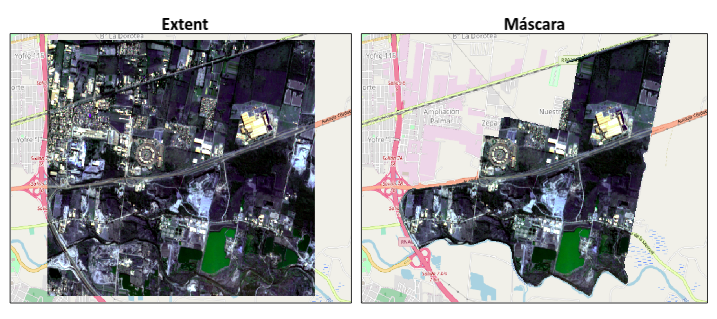

Les  dejamos una función que guarda el raster con Rasterio, de manera análoga a la función de GDAL que presentamos en la Clase 03. La pueden agregar a su repositorio de funciones para reutilizar en las próximas clases:

```python
def guardar_GTiff(fn,crs,transform,a,nodata = 0, dtype = np.float32):
        if len(a.shape)==2:
            count=1
        else:
            count=a.shape[0]
        with rasterio.open(
        fn,
        'w',
        driver='GTiff',
        height=a.shape[-2],
        width=a.shape[-1],
        count=count,
        dtype=dtype,
        nodata = nodata,
        crs=crs,
        transform=transform) as dst:
            if len(a.shape)==2:
                dst.write(a.astype(dtype), 1)
            else:
                for b in range(0,count):
                    dst.write(a[b].astype(dtype), b+1)

# Prueba de la función
guardar_GTiff('../data/out/S2_mask_prueba_funcion.tif',32720,mask_transform,s2_mask, dtype = np.uint16)
```

### Generalizando a más de un polígono

Si quisiéramos hacer un recorte enmascarado por cada uno de los polígonos que componen la capa de radios, podríamos armar un ciclo _for_ que la vaya recorriendo, generar el recorte y guardarlo con un identificador único, que podría ser el código de cada radio. La celda de abajo puede demorar un poco en correr, pero cuando termine de ejecutarse, observá el resultado en tu carpeta **proc**:

```python
import os

for c in radios.link:
    radio = radios[radios.link == c]
    recorte_masked,transform =  mask(dataset=s2,shapes = radio.geometry, crop = True)
    ruta_out = '../data/proc'
    nombre = f'S2_mask_{c}'
    outfile = os.path.join(ruta_out,nombre)
    guardar_GTiff(outfile,32720,transform,recorte_masked)
```

### Ejercicio 2.1

a) Probar qué sucede con el tamaño y extensión espacial de los archivos guardados como GeoTiff cuando en el comando Mask se configura el parámetro **crop** como False. Buscar en la documentación de Rasterio a qué se refiere este parámetro.

b) Abrir la imagen SPOT (puede ser alguna de sus bandas, la banda pancromática o el apilado de 4 bandas) y recortarla al igual que la imagen Sentinel-2- Guardar los recortes como archivos GeoTiff.

## 4. Reproyección de archivos

Ahora que hemos incorporado Rasterio y Geopandas, vamos a aprovechar sus herramientas para ver cómo hacemos para reproyectar nuestros archivos a otro sistema de coordenadas.

Comenzaremos por los vectores, ya que el método que ofrece Geopandas es sumamente simple: Lo hacemos con el método **to_crs()**, al cual le podemos pasar como parámetro el código EPSG que le corresponde al sistema de referencia nuevo. Por ejemplo si queremos re-proyectar nuestros radios a EPSG:4326, debemos ejecutar:

```python
radios_4326 = radios.to_crs(4326)

#Los guardamos en ../data/out
radios_4326.to_file('../data/out/radios_4326.gpkg')
```

En el caso de los archivos raster, el proceso no es tan sencillo, , dado que la proyección implica calcular unas nuevas transformaciones, así como una nueva matriz de datos que posiblemente tendrá un número diferente de filas y columnas. El proceso que vamos a llevar a cabo entonces es el siguiente:

- Calcular los parámetros de geotransformación de la imagen de salida, para lo cual utilizaremos la herramienta [calculate_default_transform](https://rasterio.readthedocs.io/en/latest/api/rasterio.warp.html#rasterio.warp.calculate_default_transform). A esta herramienta le pasaremos los siguientes parámetros:
  - **Sistema de referencia origen**: lo tenemos en los metadatos de la imagen fuente
  - **Sistema de referencia destino**: lo calculamos a partir del EPSG
  - **Dimensiones de la matriz origen**: lo tenemos en los metadatos
  - **Extensión de la capa origen**: lo calculamos a partir de la altura y las transformaciones de la imagen fuente. Para esto utilizamos la herramienta [array_bounds](https://rasterio.readthedocs.io/en/latest/api/rasterio.transform.html) de rasterio. Aquí también podríamos aprovechar la variable **s2_plot_extent** que definimos más arriba, ya que tiene la misma información (aunque en un orden distinto!!!).
  - **Resolución de salida**: lo establecemos nosotros


- Proyectar el array, aquí utilizaremos la herramienta [reproject](https://rasterio.readthedocs.io/en/latest/topics/reproject.html#:~:text=Rasterio%20can%20map%20the%20pixels%20of%20a%20destination,and%20transform.%20This%20process%20is%20known%20as%20reprojection.) de rasterio. Los parámetros necesarios son:
  - Matriz de datos a proyectar
  - Matriz vacía donde escribiremos nuestro resultado
  - Geotransformación origen
  - Sistema de referencia origen
  - Geotransformación de los datos de salida
  - Sistema de referencia destino
  - Valor _no data_ para los datos de salida


- Finalmente, construiremos nuestros metadatos para la nueva imagen teniendo en cuenta los parámetros calculados.

Para el primer paso, necesitamos entonces calcular la extensión de nuestra capa origen, así como definir el sistema de referencia de la capa destino. Esto lo realizamos de la siguiente manera:

```python
from rasterio.crs import CRS
from rasterio.warp import reproject, calculate_default_transform
from rasterio.transform import array_bounds
from rasterio.features import shapes

# Calcular la extensión de la capa:
metadata = s2.meta
src_bounds = array_bounds(metadata['height'], 
                          metadata['width'], 
                          metadata['transform'])

# Establecer el sistema de referencia de destino:
dst_crs = CRS.from_epsg(4326)
```

Ahora sí, podemos calcular las geotransformaciones, así como las dimensiones de nuestra imagen de salida (fijarse en los valores que pasamos dentro de **resolution**):

```python
dst_transform, dst_width, dst_height = calculate_default_transform(metadata['crs'],
                                                                   dst_crs,
                                                                   metadata['width'],
                                                                   metadata['height'],
                                                                   *src_bounds,
                                                                   resolution=(0.0001, 0.0001))
```

El segundo paso consiste en proyectar nuestra imagen. Para esto ya hemos calculado los parámetros necesarios. Lo único que nos hace falta es definir una matriz vacía donde guardar nuestra imagen resultante. Esto lo podemos realizar de dos maneras:

```python
nbandas = s2_bandas.shape[0] 
s2_4326 = np.zeros((nbandas,dst_height, dst_width),dtype='float32')

```

Una vez definida nuestra matriz de destino, con las nuevas dimensiones, lo siguiente será proyectar los datos:

```python
reproject(source=s2_bandas,
          destination=s2_4326,
          src_transform=metadata['transform'],
          src_crs=metadata['crs'],
          dst_transform=dst_transform,
          dst_crs=dst_crs,
          dst_nodata=metadata['nodata'])
```

Finalmente, vamos a construir nuestros nuevos metadatos:

```python
metadata_4326 = metadata.copy()
metadata_4326['dtype'] = 'float32'
metadata_4326['width'] = dst_width
metadata_4326['height'] = dst_height
metadata_4326['transform'] = dst_transform
metadata_4326['crs'] = dst_crs
#Agregamos explícitamente que 0 sea considerado como nodata:
metadata_4326['nodata'] = 0

print(metadata)
print(metadata_4326)
```

Y ahora sí, podemos guardar nuestra matriz reproyectada como GeoTiff:

```python
with rasterio.open('../data/out/S2_4326.tif', "w", **metadata_4326) as dest:
        dest.write(s2_4326)

# Prueba de la función
guardar_GTiff('../data/out/S2_4326_funcion.tif',4326,dst_transform,s2_4326)
```

Una manera de hacer los pasos anteriores de manera mucho más concisa (pero también a mucho más alto nivel, y menos control de las variables) es usando la biblioteca `rioxarray`, que tiene su propia función de reproyección. Para ello, primero deberás instalarla:

```python
pip install rioxarray
```

Y luego correr el siguiente código:

```python
import rioxarray

# Cargar el raster
raster = rioxarray.open_rasterio("../data/raw_data/S2_20180619_2-3-4-8-11-12.tif")

# Reproyectar
reprojected = raster.rio.reproject("EPSG:4326")

# Guardar
reprojected.rio.to_raster("../data/out/S2_4326_rioxarray.tif")
```